## ****House Price Prediction Project****

#### **Overview**

This project aims to predict house selling prices based on various features like area, number of bedrooms, location, etc. using the dataset from Kaggle's "House Prices: Advanced Regression Techniques" competition.

***Step 1: Data Loading and Initial Exploration***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for plots
sns.set_style("whitegrid")
sns.set_palette("husl")

In [3]:
# Load the data
def load_data():
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    print("Train data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    
    # Basic data quality checks
    print("\nData types:\n", train_data.dtypes.value_counts())
    
    return train_data, test_data

train_data, test_data = load_data()

Train data shape: (1460, 81)
Test data shape: (1459, 80)

Data types:
 object     43
int64      35
float64     3
Name: count, dtype: int64


***Step 2: Exploratory Data Analysis (EDA)***

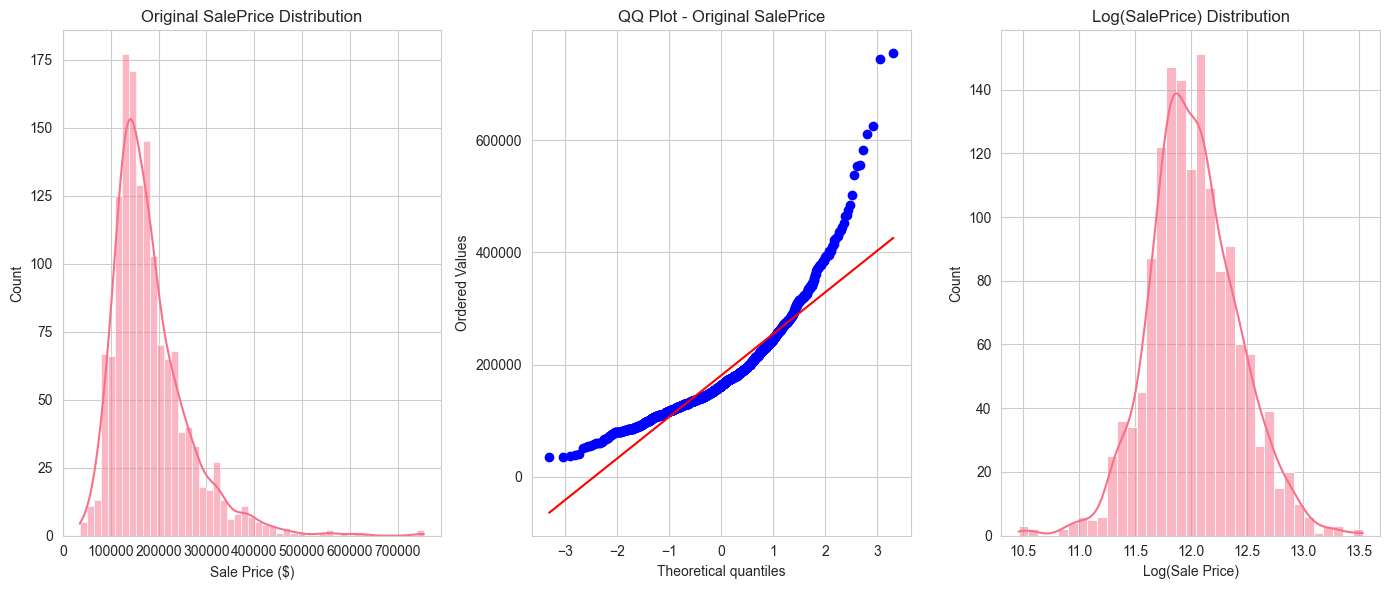

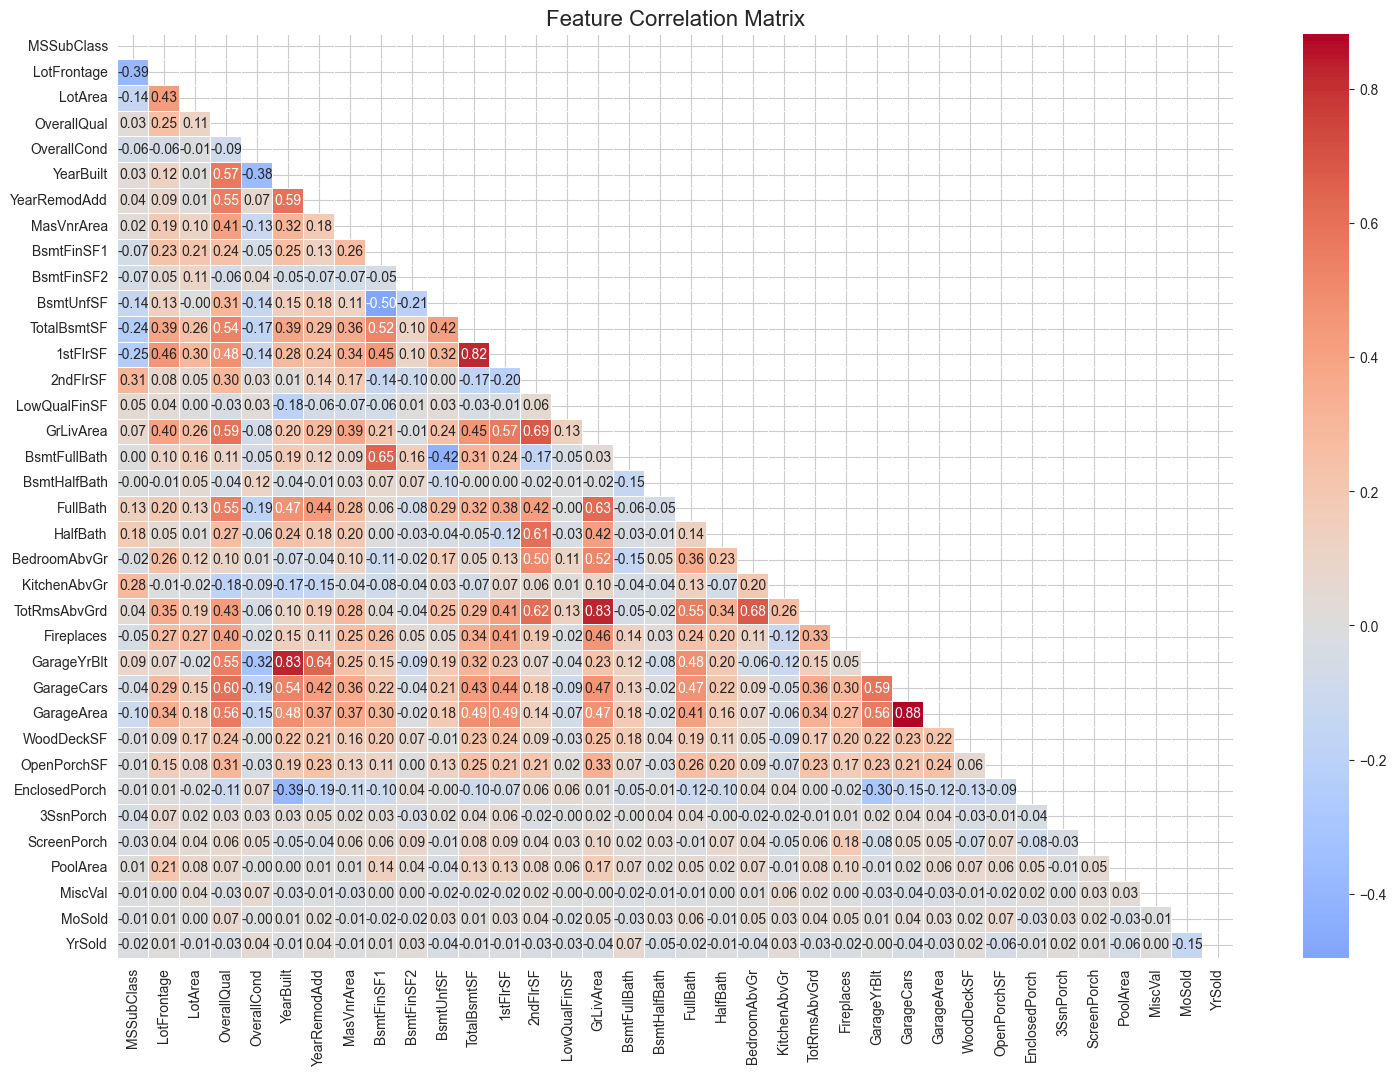

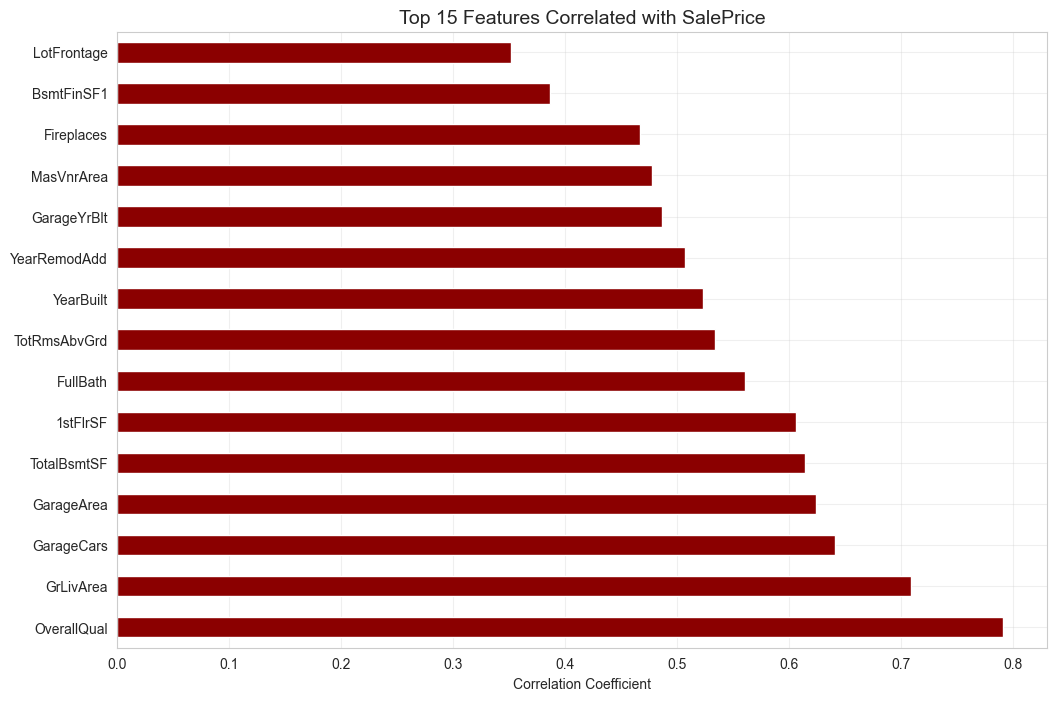

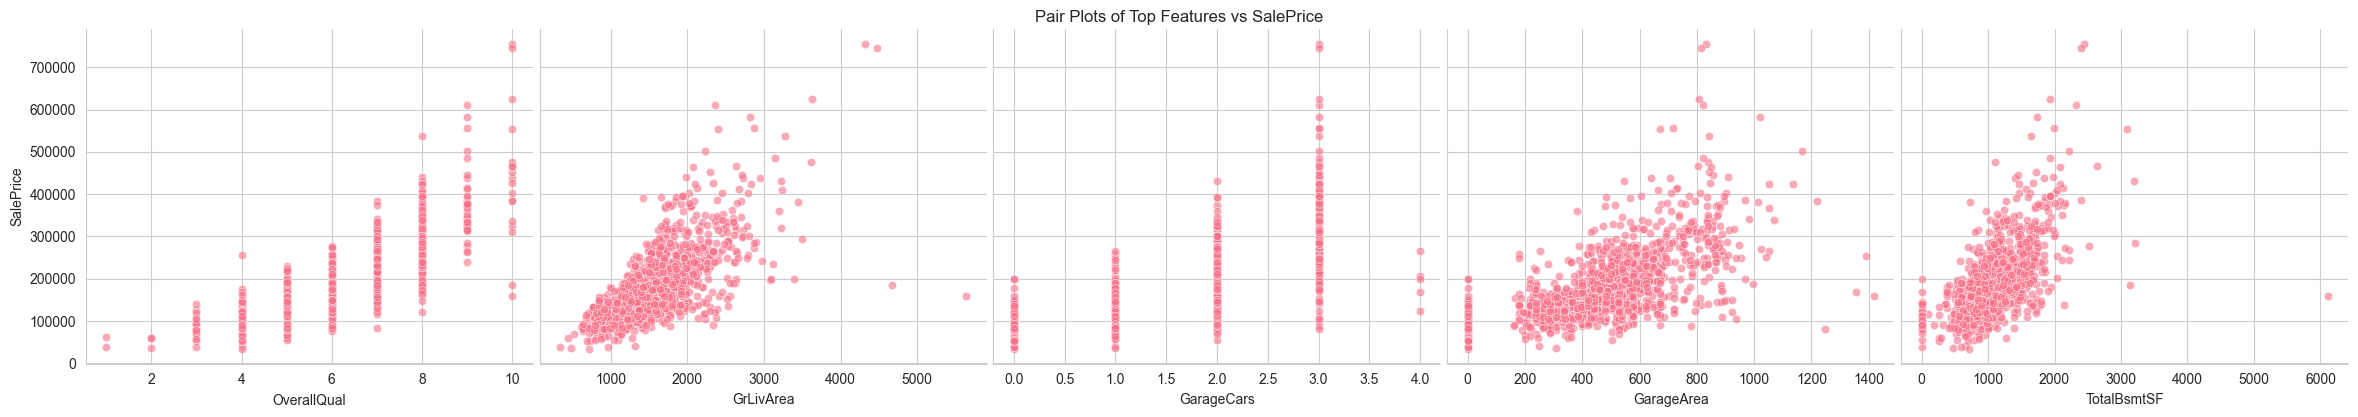

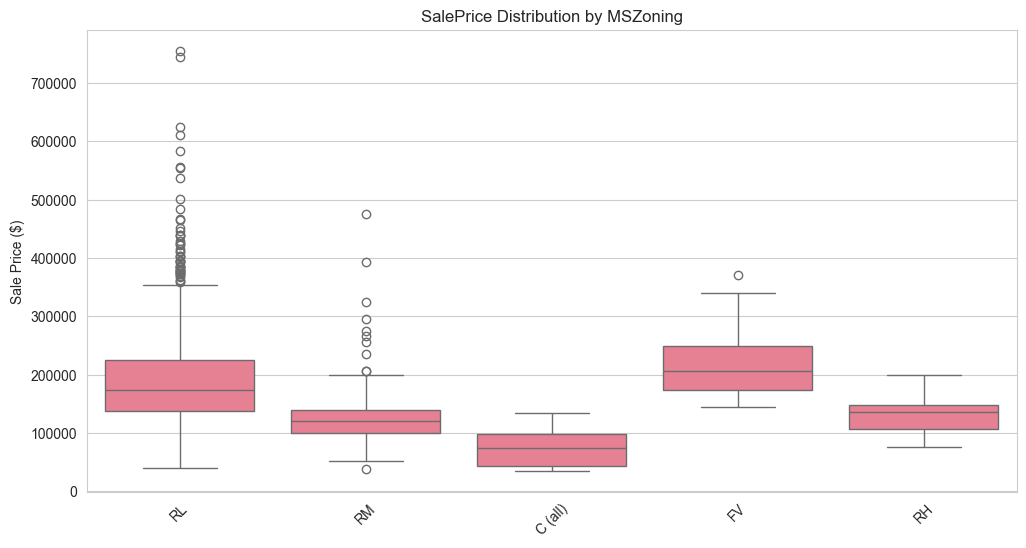

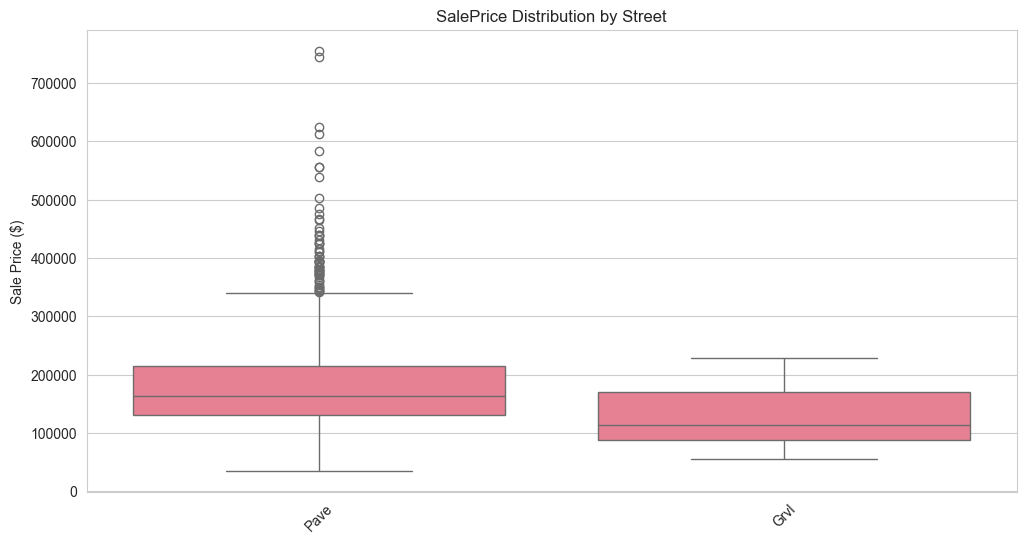

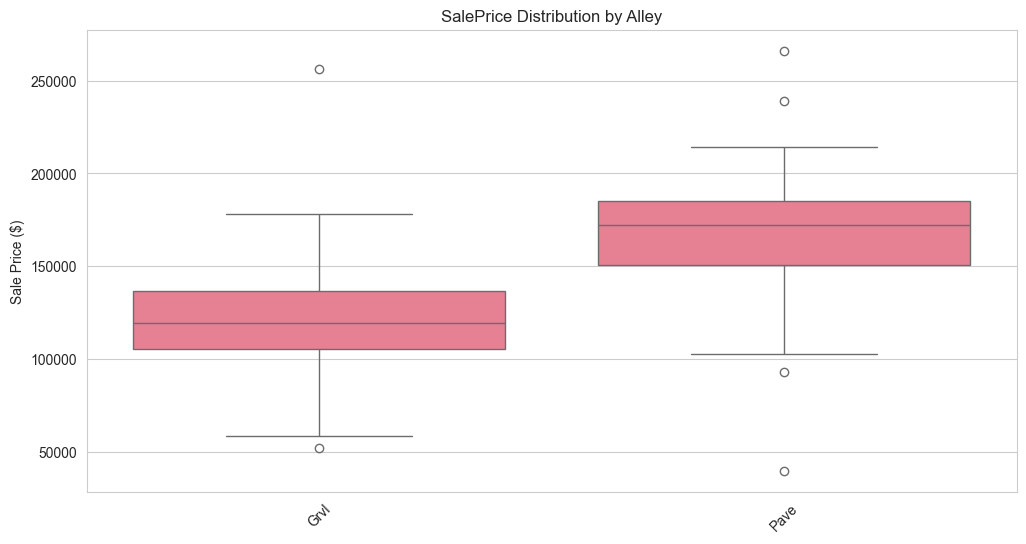

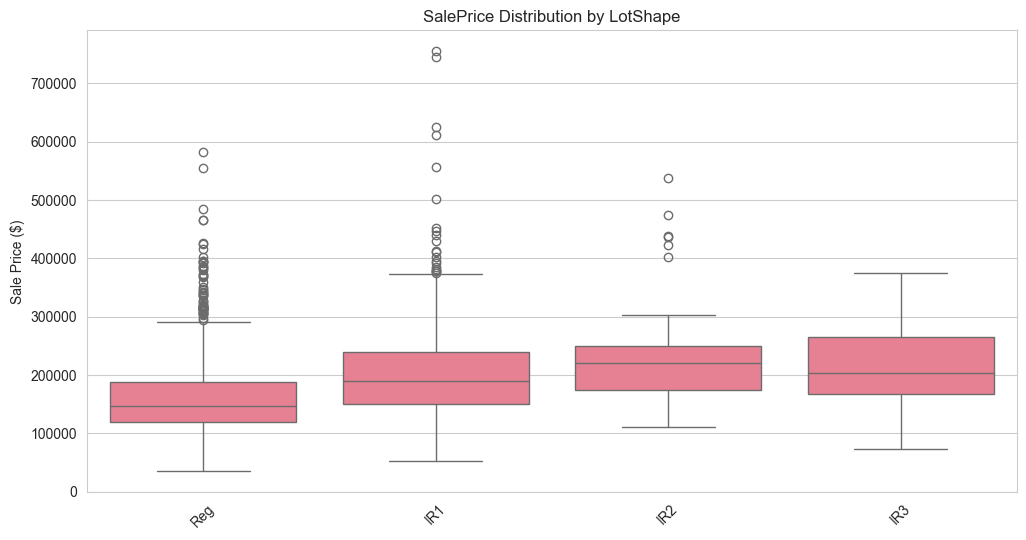

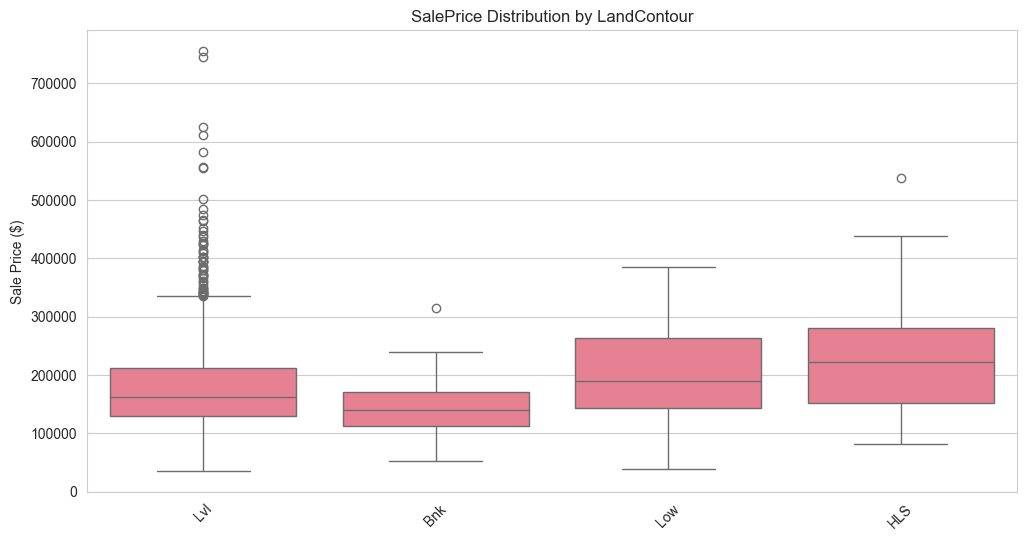

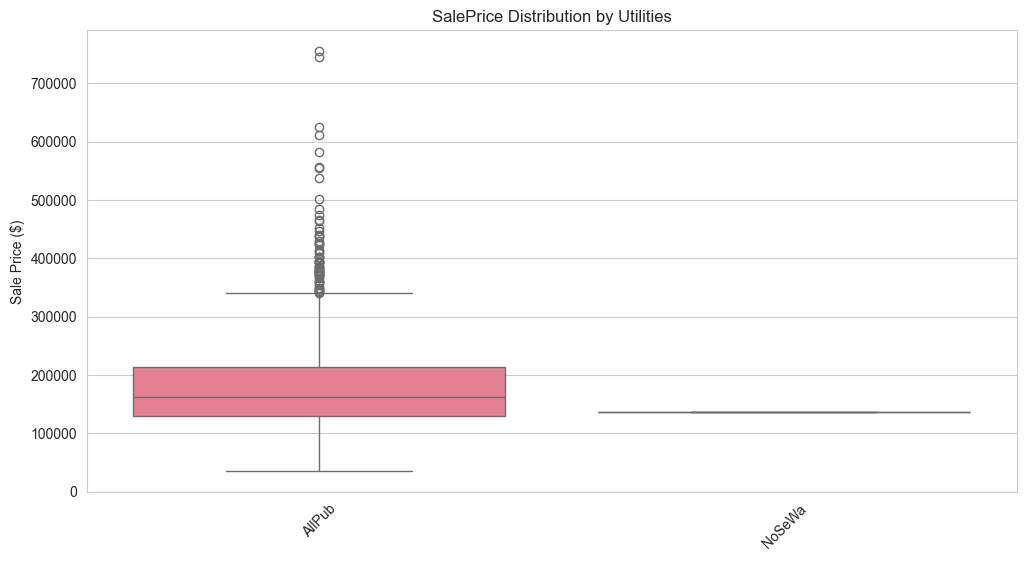

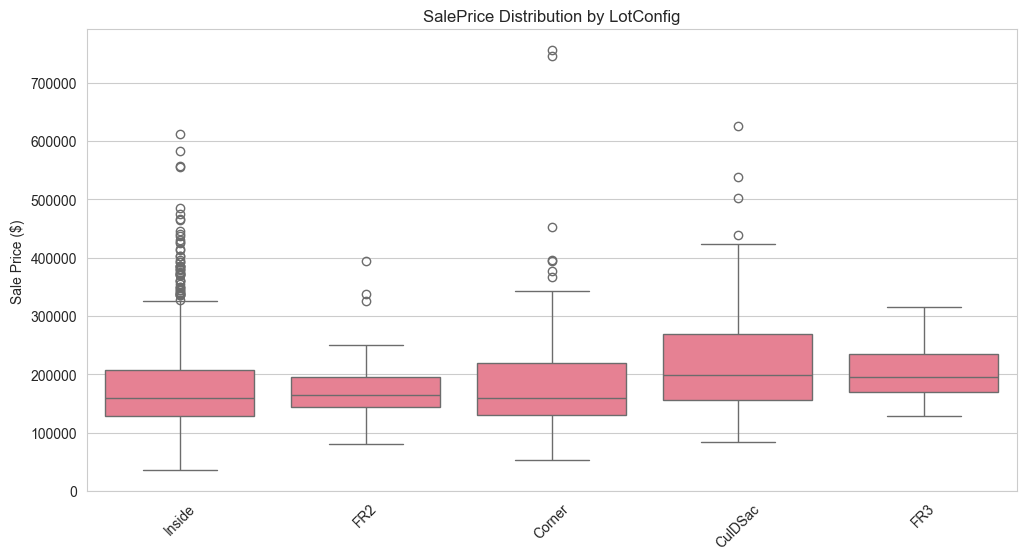

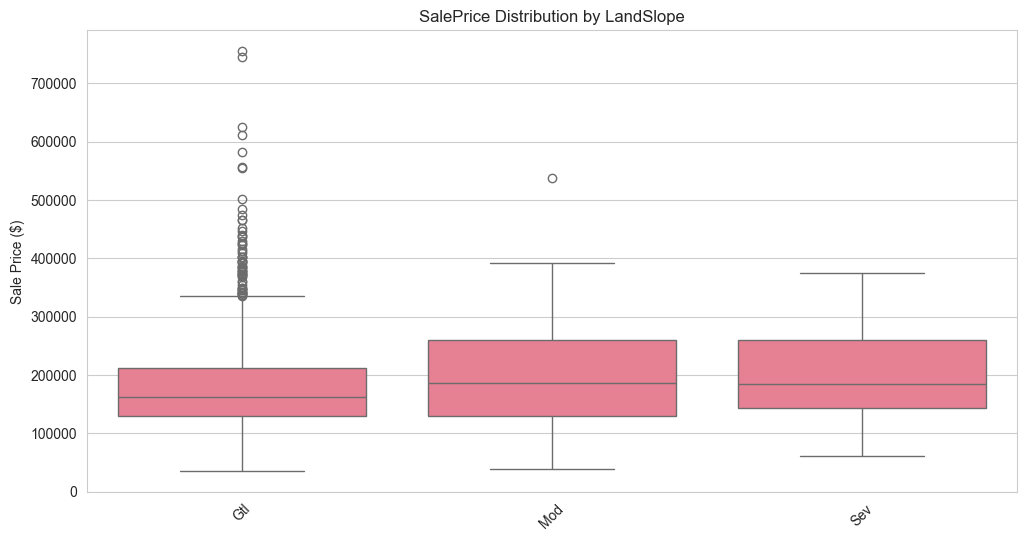

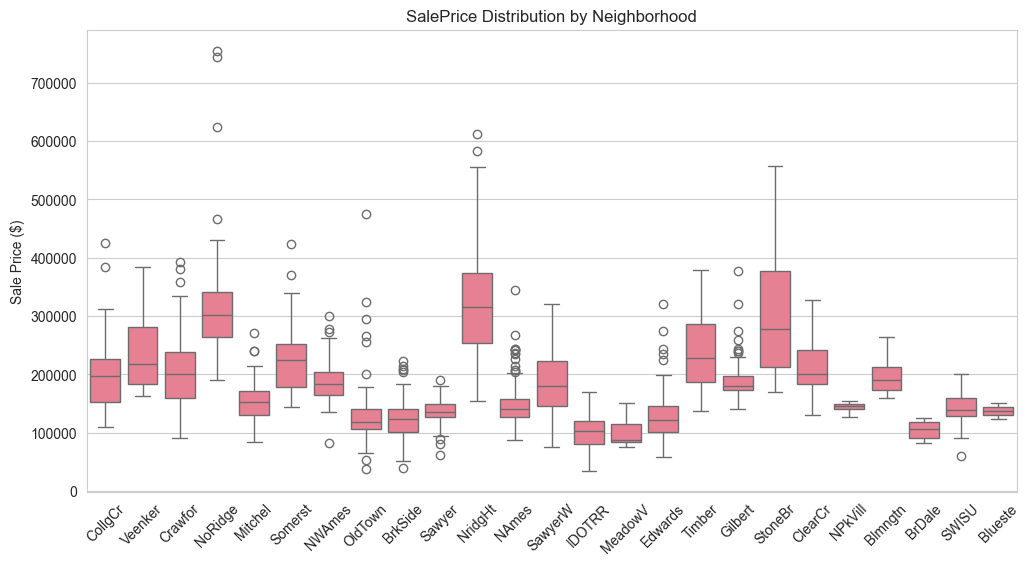

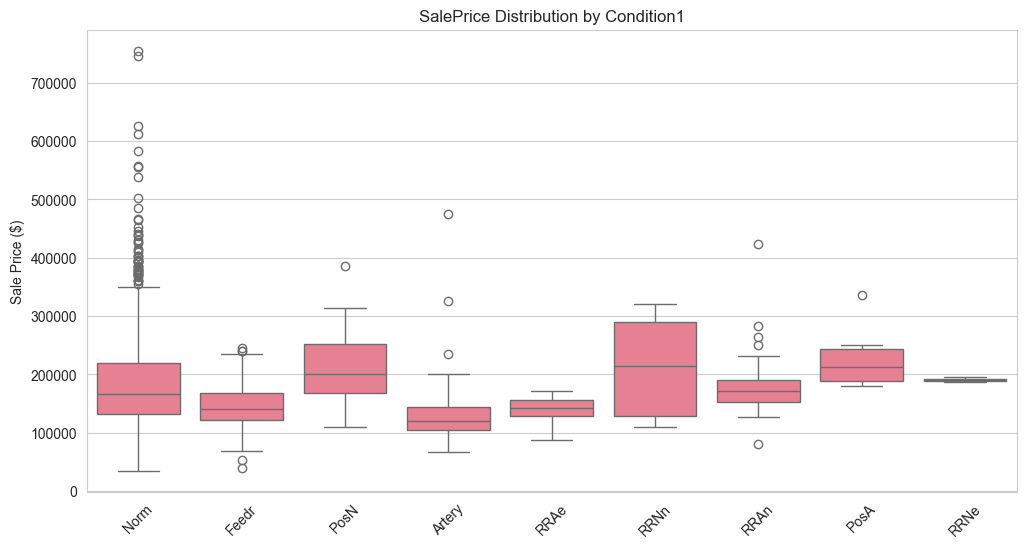

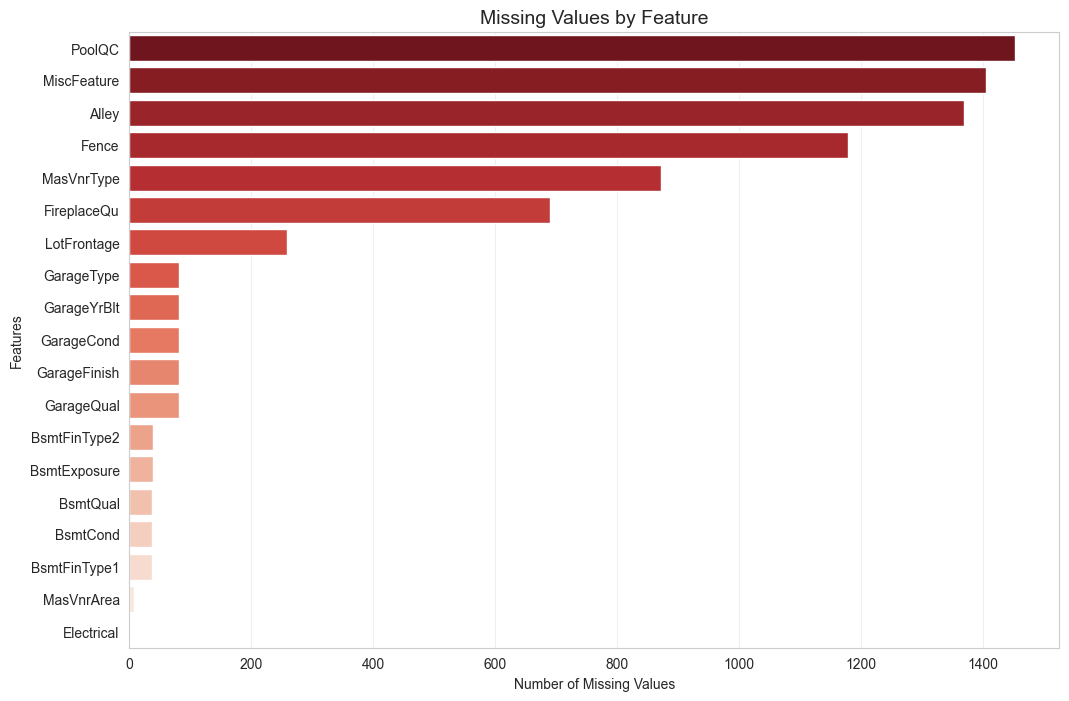

In [4]:
def perform_eda(data):
    # 1. Enhanced Target Variable Analysis
    plt.figure(figsize=(14, 6))
    
    # Before log transformation
    plt.subplot(1, 3, 1)
    sns.histplot(data['SalePrice'], kde=True)
    plt.title('Original SalePrice Distribution')
    plt.xlabel('Sale Price ($)')
    
    # QQ plot for normality check
    plt.subplot(1, 3, 2)
    stats.probplot(data['SalePrice'], plot=plt)
    plt.title('QQ Plot - Original SalePrice')
    
    # After log transformation
    data['LogSalePrice'] = np.log1p(data['SalePrice'])
    plt.subplot(1, 3, 3)
    sns.histplot(data['LogSalePrice'], kde=True)
    plt.title('Log(SalePrice) Distribution')
    plt.xlabel('Log(Sale Price)')
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation Analysis with Heatmap
    numerical_features = data.select_dtypes(include=['int64', 'float64'])
    numerical_features = numerical_features.drop(['Id', 'SalePrice', 'LogSalePrice'], axis=1, errors='ignore')
    
    plt.figure(figsize=(18, 12))
    corr_matrix = numerical_features.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
                annot=True, fmt=".2f", linewidths=.5)
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.show()
    
    # Top correlated features with SalePrice
    corr_with_price = numerical_features.corrwith(data['SalePrice']).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    corr_with_price.head(15).plot(kind='barh', color='darkred')
    plt.title('Top 15 Features Correlated with SalePrice', fontsize=14)
    plt.xlabel('Correlation Coefficient')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Interactive Pair Plots for Top Features
    top_features = corr_with_price.index[:5]
    sns.pairplot(data, x_vars=top_features, y_vars=['SalePrice'], 
                 height=4, aspect=1.2, plot_kws={'alpha':0.6})
    plt.suptitle('Pair Plots of Top Features vs SalePrice', y=1.02)
    plt.show()
    
    # 4. Categorical Features Analysis
    categorical_features = data.select_dtypes(include=['object']).columns
    
    for feature in categorical_features[:10]:  # Limit to first 10 for brevity
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=data[feature], y=data['SalePrice'])
        plt.xticks(rotation=45)
        plt.title(f'SalePrice Distribution by {feature}', fontsize=12)
        plt.xlabel('')
        plt.ylabel('Sale Price ($)')
        plt.show()
    
    # 5. Missing Data Visualization
    missing_data = data.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data > 0]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=missing_data.values, y=missing_data.index, palette='Reds_r')
    plt.title('Missing Values by Feature', fontsize=14)
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Features')
    plt.grid(axis='x', alpha=0.3)
    plt.show()

perform_eda(train_data)

***Step 3: Advanced Data Preprocessing***

In [5]:
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(train, test):
    # Separate features and target
    X_train = train.drop(['Id', 'SalePrice', 'LogSalePrice'], axis=1, errors='ignore')
    y_train = train['LogSalePrice']  # Using log-transformed target
    
    X_test = test.drop(['Id'], axis=1)
    test_ids = test['Id']
    
    # Identify feature types
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
    
    # Enhanced numerical preprocessing
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('transformer', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ])
    
    # Enhanced categorical preprocessing (updated for scikit-learn 1.2+)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Removed sparse parameter
    ])
    
    # Feature selection
    feature_selector = SelectKBest(score_func=f_regression, k=50)
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector)
    ])
    
    # Apply preprocessing
    X_train_preprocessed = full_pipeline.fit_transform(X_train, y_train)
    X_test_preprocessed = full_pipeline.transform(X_test)
    
    # Get feature names (updated for new OneHotEncoder)
    num_features = numerical_features
    cat_encoder = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_features = cat_encoder.get_feature_names_out(categorical_features)
    all_features = np.concatenate([num_features, cat_features])
    selected_features = all_features[full_pipeline.named_steps['feature_selection'].get_support()]
    
    return X_train_preprocessed, y_train, X_test_preprocessed, test_ids, selected_features

In [6]:
X_train_preprocessed, y_train, X_test_preprocessed, test_ids, selected_features = preprocess_data(train_data, test_data)

***Step 4: Advanced Model Building with Hyperparameter Tuning***

In [7]:


def build_and_evaluate_models(X_train, y_train):
    # Define models with initial parameters
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42),
        'LightGBM': lgb.LGBMRegressor(random_state=42)
    }
    
    # Parameter grids for GridSearch
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 50],
            'max_depth': [-1, 5]
        }
    }
    
    results = {}
    best_models = {}
    
    for name, model in models.items():
        print(f"\n=== Tuning {name} ===")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(model, param_grids[name], 
                                 cv=5, 
                                 scoring='neg_mean_squared_error',
                                 n_jobs=-1,
                                 verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Store results
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        
        # Cross-validation scores
        cv_scores = cross_val_score(best_model, X_train, y_train, 
                                   cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)
        
        results[name] = {
            'best_params': grid_search.best_params_,
            'cv_mean_rmse': cv_rmse.mean(),
            'cv_std_rmse': cv_rmse.std()
        }
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    
    return best_models, results

best_models, model_results = build_and_evaluate_models(X_train_preprocessed, y_train)


=== Tuning Random Forest ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
CV RMSE: 0.1517 ± 0.0097

=== Tuning Gradient Boosting ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
CV RMSE: 0.1420 ± 0.0111

=== Tuning XGBoost ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
CV RMSE: 0.1418 ± 0.0116

=== Tuning LightGBM ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 50
[LightGBM] [Info] Start t

***Step 5: Model Evaluation and Interpretation***


=== Best Model: XGBoost ===
Cross-Validated RMSE: 0.1418


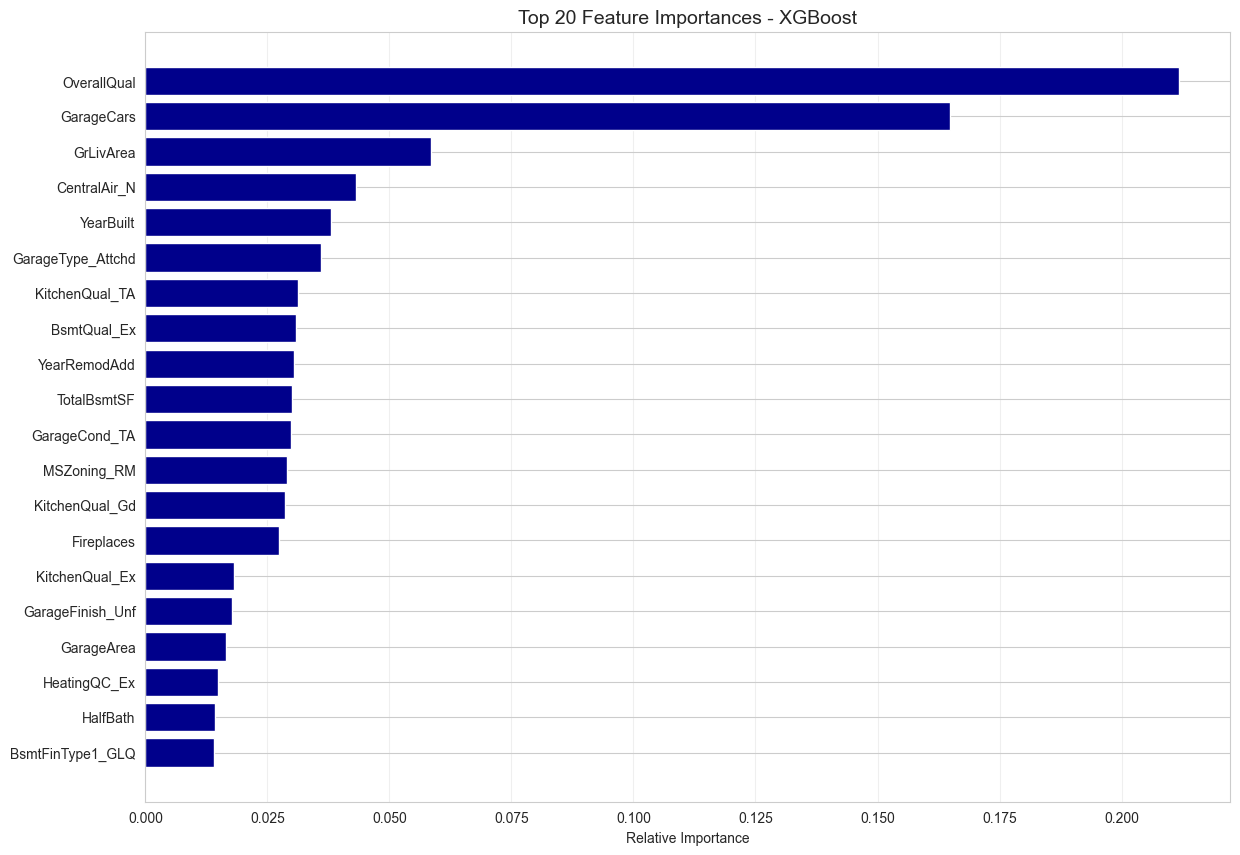

SHAP visualization not available for this model type


In [8]:
def evaluate_and_interpret(best_models, model_results, X_train, y_train, feature_names):
    # Find the best model
    best_model_name = min(model_results, key=lambda x: model_results[x]['cv_mean_rmse'])
    best_model = best_models[best_model_name]
    
    print(f"\n=== Best Model: {best_model_name} ===")
    print(f"Cross-Validated RMSE: {model_results[best_model_name]['cv_mean_rmse']:.4f}")
    
    # Feature Importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[-20:]  # Top 20 features
        
        plt.figure(figsize=(14, 10))
        plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14)
        plt.barh(range(len(indices)), importances[indices], align='center', color='darkblue')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.grid(axis='x', alpha=0.3)
        plt.show()
    
    # SHAP values for model interpretation (if available)
    try:
        import shap
        
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_train)
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")
        plt.title('SHAP Feature Importance', fontsize=14)
        plt.show()
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_train, feature_names=feature_names)
        plt.title('SHAP Value Distribution', fontsize=14)
        plt.show()
    except:
        print("SHAP visualization not available for this model type")

evaluate_and_interpret(best_models, model_results, X_train_preprocessed, y_train, selected_features)

***Step 6: Final Prediction and Submission***

In [9]:
def create_submission(best_models, model_results, X_train, y_train, X_test, test_ids):
    # Select the best model
    best_model_name = min(model_results, key=lambda x: model_results[x]['cv_mean_rmse'])
    best_model = best_models[best_model_name]
    
    # Retrain on full dataset
    best_model.fit(X_train, y_train)
    
    # Make predictions
    test_preds_log = best_model.predict(X_test)
    test_preds = np.expm1(test_preds_log)  # Convert back from log scale
    
    # Create submission file
    submission = pd.DataFrame({'Id': test_ids, 'SalePrice': test_preds})
    submission.to_csv('submission.csv', index=False)
    
    print("\n=== Submission File Created ===")
    print(f"Used model: {best_model_name}")
    print(f"Predicted price range: ${test_preds.min():,.2f} - ${test_preds.max():,.2f}")
    
    return submission

final_submission = create_submission(best_models, model_results, 
                                    X_train_preprocessed, y_train, 
                                    X_test_preprocessed, test_ids)


=== Submission File Created ===
Used model: XGBoost
Predicted price range: $43,560.52 - $516,962.41
